#### Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv('bank-full.csv', delimiter=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


#### Data preparation

In [4]:
required_features = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]

data = data[required_features]
data.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
data['y'].value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [6]:
data.y = (data.y == 'yes').astype(int)
data['y'].value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [7]:
categorical_features = list(data.dtypes[data.dtypes == 'object'].index)
for col in categorical_features:
    print(f'{col}:')
    print(data[col].unique())

job:
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital:
['married' 'single' 'divorced']
education:
['tertiary' 'secondary' 'unknown' 'primary']
housing:
['yes' 'no']
contact:
['unknown' 'cellular' 'telephone']
month:
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome:
['unknown' 'failure' 'other' 'success']


In [8]:
numerical_features = list(data.dtypes[data.dtypes != 'object'].index)
for col in numerical_features:
    print(f'{col}:', data[col].nunique())

age: 77
balance: 7168
day: 31
duration: 1573
campaign: 48
pdays: 559
previous: 41
y: 2


In [9]:
data.shape

(45211, 15)

In [10]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print("df_full_train: ", len(df_full_train))
print("df_train: ", len(df_train))
print("df_val: ", len(df_val))
print("df_test: ", len(df_test))

df_full_train:  36168
df_train:  27126
df_val:  9042
df_test:  9043


In [11]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

#### Question 1: ROC AUC feature importance

In [13]:
numerical_variables = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
for variable in numerical_variables:
    score = roc_auc_score(y_train, df_train[variable])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[variable])  
    print(f'{variable}: {score}')

age: 0.512185717527344
balance: 0.5888313805382317
day: 0.525957882383908
duration: 0.8147002759670778
campaign: 0.5714543015682159
pdays: 0.5901276247352144
previous: 0.5985653242764153


#### Question 2: Training the model

In [14]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:, 1]

In [15]:
roc_auc_score(y_val, y_pred)

0.900416187446919

#### Question 3: Precision and Recall

In [16]:
scores = []
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
 
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
 
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
 
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
 
    scores.append((t, tp, tn, fp, fn))
 
scores

[(0.0, 1098, 0, 7944, 0),
 (0.01, 1094, 940, 7004, 4),
 (0.02, 1093, 2156, 5788, 5),
 (0.03, 1087, 3202, 4742, 11),
 (0.04, 1068, 4144, 3800, 30),
 (0.05, 1048, 4871, 3073, 50),
 (0.06, 1020, 5434, 2510, 78),
 (0.07, 993, 5803, 2141, 105),
 (0.08, 969, 6085, 1859, 129),
 (0.09, 945, 6311, 1633, 153),
 (0.1, 927, 6451, 1493, 171),
 (0.11, 899, 6588, 1356, 199),
 (0.12, 862, 6727, 1217, 236),
 (0.13, 836, 6828, 1116, 262),
 (0.14, 816, 6906, 1038, 282),
 (0.15, 798, 6970, 974, 300),
 (0.16, 781, 7050, 894, 317),
 (0.17, 763, 7103, 841, 335),
 (0.18, 744, 7163, 781, 354),
 (0.19, 727, 7214, 730, 371),
 (0.2, 712, 7252, 692, 386),
 (0.21, 696, 7291, 653, 402),
 (0.22, 686, 7333, 611, 412),
 (0.23, 667, 7371, 573, 431),
 (0.24, 648, 7394, 550, 450),
 (0.25, 635, 7429, 515, 463),
 (0.26, 619, 7450, 494, 479),
 (0.27, 603, 7476, 468, 495),
 (0.28, 593, 7495, 449, 505),
 (0.29, 578, 7511, 433, 520),
 (0.3, 565, 7536, 408, 533),
 (0.31, 553, 7551, 393, 545),
 (0.32, 546, 7569, 375, 552),
 (0.33

In [17]:
columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores.head()

,threshold,tp,tn,fp,fn,precision,recall
0,0.00,1098,0,7944,0,0.121433,1.000000
1,0.01,1094,940,7004,4,0.135095,0.996357
2,0.02,1093,2156,5788,5,0.158843,0.995446
3,0.03,1087,3202,4742,11,0.186481,0.989982
4,0.04,1068,4144,3800,30,0.219392,0.972678


In [18]:
df_scores[round(df_scores.precision, 2) == round(df_scores.recall, 2)]

,threshold,tp,tn,fp,fn,precision,recall
26,0.26,619,7450,494,479,0.556155,0.563752


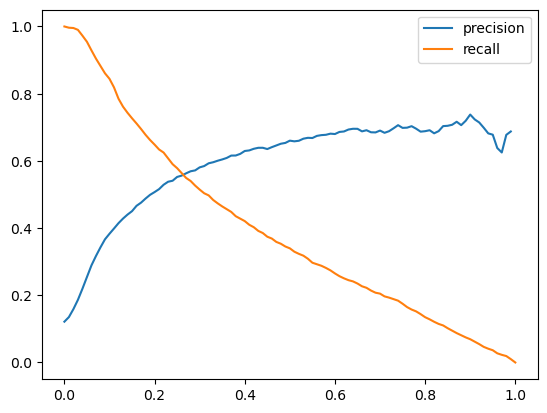

In [19]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.legend()
plt.show()

#### Question 4: F1 score

In [20]:
df_scores['f1'] = 2 * ( (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall))

In [21]:
df_scores.head()

,threshold,tp,tn,fp,fn,precision,recall,f1
0,0.00,1098,0,7944,0,0.121433,1.000000,0.216568
1,0.01,1094,940,7004,4,0.135095,0.996357,0.237930
2,0.02,1093,2156,5788,5,0.158843,0.995446,0.273969
3,0.03,1087,3202,4742,11,0.186481,0.989982,0.313844
4,0.04,1068,4144,3800,30,0.219392,0.972678,0.358029


In [22]:
df_scores[df_scores.f1 == max(df_scores.f1)]

,threshold,tp,tn,fp,fn,precision,recall,f1
22,0.22,686,7333,611,412,0.528913,0.624772,0.57286


#### Question 5: 5-Fold CV

In [28]:
columns = [    
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
]

In [29]:
def train(df_train, y_train):
    dicts = df_train[columns].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
 
    return dv, model

In [30]:
def predict(df, dv, model):
     dicts = df[columns].to_dict(orient='records')
     X = dv.transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
     return y_pred

In [31]:
scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
 
scores

[0.8993454076910828,
 0.8993071840663719,
 0.9111830172937582,
 0.9082408660097206,
 0.9121745763212716]

In [33]:
print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.906 +- 0.006


#### Question 6: Hyperparameter Tuning

In [34]:
def train(df_train, y_train, C=1):
    dicts = df_train[columns].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
 
    return dv, model

In [35]:
def predict(df, dv, model):
     dicts = df[columns].to_dict(orient='records')
     X = dv.transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
     return y_pred

In [37]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
     
    scores = []
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.y.values
        y_val = df_val.y.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.701 +- 0.009
C=0.001 0.861 +- 0.007
C=1 0.906 +- 0.006
